In [0]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='tensorflow'
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline
MAX_SENT_LENGTH = 100
MAX_SENTS = 20
MAX_NB_WORDS = 25000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [0]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [28]:
# reading data
df = pd.read_csv('/gdrive/My Drive/movie_review_small.csv',encoding = "ISO-8859-1")
df = df.dropna()
df = df.reset_index(drop=True)
print(df.shape)
print(len(set(df['CLASS'])))

(5002, 6)
2


In [0]:
import nltk
from nltk import tokenize

reviews = []
labels = []
texts = []

In [0]:
macronum=sorted(set(df['CLASS']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

In [0]:
def fun(i):
    return macro_to_id[i]

df['CLASS']=df['CLASS'].apply(fun)

In [32]:
#import nltk
#nltk.download('punkt')
for i in range(df.CONTENT.shape[0]):
    text = BeautifulSoup(df.CONTENT[i])
    text=clean_str(str(text.get_text().encode()).lower())
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)


for i in df['CLASS']:
    labels.append(i)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1


In [34]:
word_index = tokenizer.word_index
print(len(word_index))

13350


In [0]:
labels = to_categorical(np.asarray(labels))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [0]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [0]:
embeddings_index = {}
f = open('/gdrive/My Drive/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector



In [0]:
# To get f1 score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=True)
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)
preds = Dense(len(macronum), activation='softmax')(l_lstm_sent)
model = Model(review_input, preds)

model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['acc',f1])


In [42]:
cp=ModelCheckpoint('model_han_.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=2,callbacks=[cp])

Instructions for updating:
Use tf.cast instead.
Train on 4002 samples, validate on 1000 samples
Epoch 1/10
4002/4002 [==============================] - 763s 191ms/step - loss: 0.2504 - acc: 0.5525 - f1: 0.5525 - val_loss: 0.2453 - val_acc: 0.5640 - val_f1: 0.5640

Epoch 00001: val_acc improved from -inf to 0.56400, saving model to model_han_.hdf5
Epoch 2/10
4002/4002 [==============================] - 739s 185ms/step - loss: 0.2291 - acc: 0.6292 - f1: 0.6292 - val_loss: 0.2430 - val_acc: 0.6260 - val_f1: 0.6260

Epoch 00002: val_acc improved from 0.56400 to 0.62600, saving model to model_han_.hdf5
Epoch 3/10
4002/4002 [==============================] - 741s 185ms/step - loss: 0.1968 - acc: 0.7029 - f1: 0.7029 - val_loss: 0.2130 - val_acc: 0.6580 - val_f1: 0.6580

Epoch 00003: val_acc improved from 0.62600 to 0.65800, saving model to model_han_.hdf5
Epoch 4/10
4002/4002 [==============================] - 737s 184ms/step - loss: 0.1607 - acc: 0.7676 - f1: 0.7676 - val_loss: 0.2521 - val_

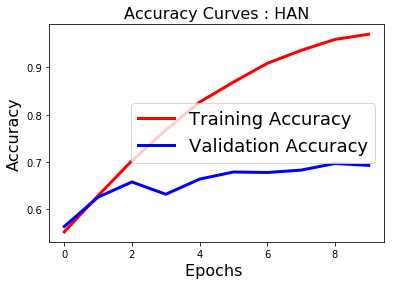

In [43]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig2.savefig('accuracy_han.png')
plt.show()

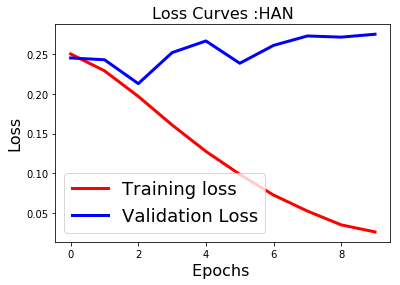

In [44]:

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :HAN',fontsize=16)
fig1.savefig('loss_han.png')
plt.show()

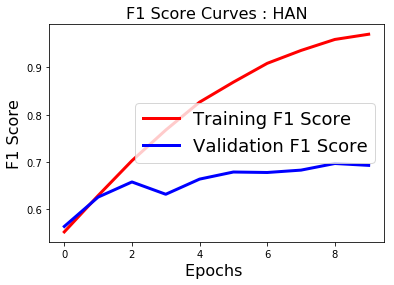

In [45]:
fig3=plt.figure()
plt.plot(history.history['f1'],'r',linewidth=3.0)
plt.plot(history.history['val_f1'],'b',linewidth=3.0)
plt.legend(['Training F1 Score', 'Validation F1 Score'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('F1 Score',fontsize=16)
plt.title('F1 Score Curves : HAN',fontsize=16)
fig3.savefig('f1_han.png')
plt.show()

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 20, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 200)           1495900   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 1,737,102
Trainable params: 1,737,102
Non-trainable params: 0
_________________________________________________________________


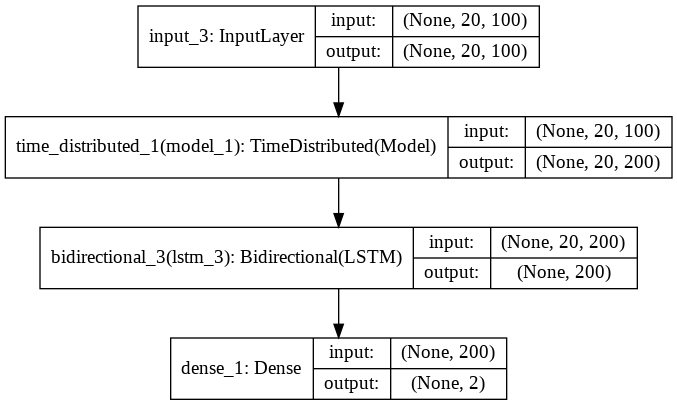

In [47]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')